In [39]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re

import functools
from keras import backend as K
    
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences 
from tensorflow.python.keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D,Flatten
from keras.optimizers import Adam
from keras.initializers import Constant

from sklearn.model_selection import train_test_split

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim

In [40]:
data = pd.read_csv('data/Reviews.csv', encoding="utf-8",nrows=50000)
data = data.reindex(np.random.permutation(data.index))

In [41]:
len(data)

50000

In [42]:
reviews_text = data["Text"].values
reviews_rating = data["Score"].values

In [43]:
stop_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

In [44]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):  
        return 'a' # adjective
    elif pos_tag.startswith('V'): 
        return 'v' # verb
    elif pos_tag.startswith('R'):
        return 'r' # adverb
    else:           
        return 'n' # fallback to noun

In [45]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>',"",text)
    text = re.sub('[^a-z0-9 \.]', '', text)
    words = word_tokenize(text) 
    words = [w for w in words if w =="not" or not w in stop_words ]
    words_pos = pos_tag(words) 
    lemmatized_words = []
    
    for word, tag in words_pos:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatiser.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    text = " ".join(lemmatized_words)
    return text

In [72]:
def plot(history,loss,accuracy):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [73]:
def create(tokenizer,embedding_matrix,EMBEDDING_DIM=100):
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
    
    model.add(embedding_layer)
    model.add(Dropout(0.6))
    model.add(Conv1D(16, 5, padding='Same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.8))
    
    model.add(Conv1D(64, 4,padding='Same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.8))
    
    model.add(Conv1D(64, 3,padding='Same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Dropout(0.8))
    
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
        
    optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [74]:
def create2(tokenizer,embedding_matrix,EMBEDDING_DIM=100):
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
    
    model.add(embedding_layer)
    model.add(Dropout(0.6))
    model.add(Conv1D(16, 5, padding='Same', activation='relu'))
    model.add(MaxPooling1D())
 
    
    model.add(Conv1D(64, 4,padding='Same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    
    model.add(Conv1D(64, 3,padding='Same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
        
    optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [75]:
def evaluate(model,x_train,y_train,x_test,y_test,batch_size=128,epochs=20):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.2)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=True,batch_size=batch_size)
    plot(history,loss,accuracy)

In [50]:
SIZE = reviews_text.size
reviews = []
labels = np.zeros(SIZE)

for i in range(SIZE):
    text = str(reviews_text[i])
    rating = reviews_rating[i]
    review = text
    review = preprocess_text(review)
    reviews.append(review)
    if(rating > 3.0):
        labels[i] = 1

In [51]:
x_train,x_test,y_train,y_test = train_test_split(reviews,labels,test_size=0.2,random_state=42)

In [52]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
# Fix sequence length to MAX_SEQUENCE_LENGTH. Sequences shorter than the length are
# padded and sequences longer are truncated
x_train = pad_sequences(x_train, maxlen=60, padding='post')
x_test = pad_sequences(x_test, maxlen=60, padding='post')

In [53]:
embeddings_index = {}
f = open('data/glove.6B.100d.txt', encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [54]:
EMBEDDING_DIM = 100
num_words = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.uniform(-0.5,0.5,100)

In [55]:
def average_embedding(x_data):
    average_embedding_matrix = np.zeros((x_data.shape[0], EMBEDDING_DIM))
    for idx, embedding_vector in enumerate(x_data):
        average_embedding_vector = np.zeros((EMBEDDING_DIM, ))
        for token_index in embedding_vector:
            average_embedding_vector += embedding_matrix[token_index]
        average_embedding_vector /= len(embedding_vector)
        average_embedding_matrix[idx] = average_embedding_vector
    return average_embedding_matrix

In [56]:
x_train = average_embedding(x_train)
x_test = average_embedding(x_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          4585800   
_________________________________________________________________
dropout_33 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 100, 16)           8016      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 50, 16)            0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 50, 16)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 50, 64)            4160      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 25, 64)           

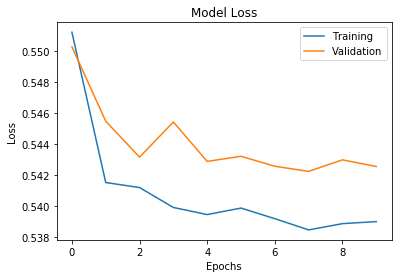

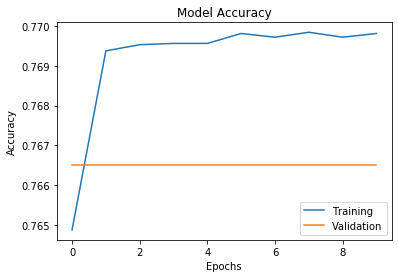


Test loss: 0.544
Test accuracy: 0.765


In [77]:
model = create(tokenizer,embedding_matrix)
evaluate(model,x_train,y_train,x_test,y_test,batch_size=128,epochs=10)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          4585800   
_________________________________________________________________
dropout_41 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 100, 16)           8016      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 50, 16)            0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 50, 16)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 50, 64)            4160      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 25, 64)          

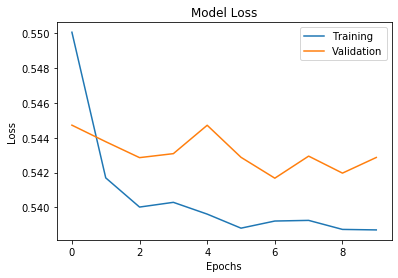

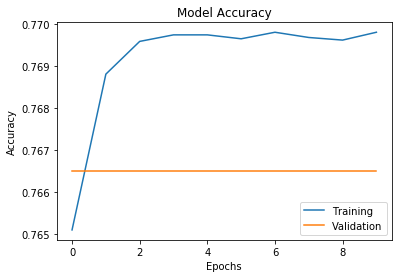


Test loss: 0.544
Test accuracy: 0.765


In [79]:
model2 = create(tokenizer,embedding_matrix)
evaluate(model2,x_train,y_train,x_test,y_test,batch_size=128,epochs=10)